<a href="https://colab.research.google.com/github/iishutov/CV-Project/blob/master/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import matplotlib.pyplot as plt

In [41]:
train_dir = '/content/drive/MyDrive/dataset/train'
test_dir = '/content/drive/MyDrive/dataset/test'

batch_size = 32
rescale = 1./255
img_height = img_width = 128

In [42]:
# Training dataset preprocessing
train_datagen = ImageDataGenerator(
    rescale=rescale,
    # rotation_range=5,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.0
)

train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42,
)

Found 574 images belonging to 2 classes.


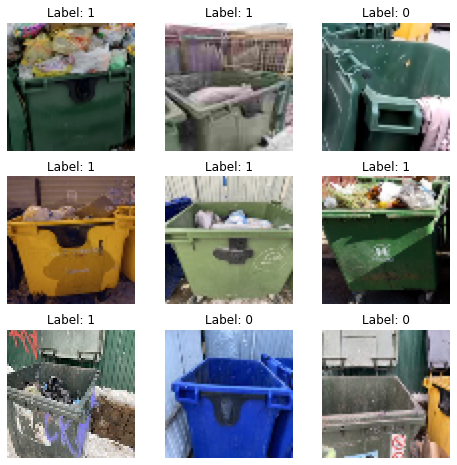

In [43]:
# Show the resulted training dataset after augmentation.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i in range(3):
    for j in range(3):
        image, label = train_dataset.next()
        axs[i,j].imshow(image[0])
        axs[i,j].set_title(f'Label: {(int)(label[0])}')
        axs[i,j].axis('off')
plt.show()

In [44]:
# ImageDataGenerator does not increase the size of the dataset.
train_dataset.n

574

In [45]:
# Testing dataset preprocessing (normalization).
test_datagen = ImageDataGenerator(rescale=rescale)

test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 101 images belonging to 2 classes.


In [46]:
# Building the convolutional base.
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Adding Dense Layers.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 flatten_14 (Flatten)        (None, 9216)            

In [47]:
# Training the model.
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
    )

history = model.fit(train_dataset, epochs=7, validation_data=test_dataset)

Epoch 1/7
18/18 [==============================] - 9s 433ms/step - loss: 0.6425 - accuracy: 0.6132 - val_loss: 0.5554 - val_accuracy: 0.7723
Epoch 2/7
18/18 [==============================] - 5s 276ms/step - loss: 0.4811 - accuracy: 0.7544 - val_loss: 0.5183 - val_accuracy: 0.7525
Epoch 3/7
18/18 [==============================] - 6s 355ms/step - loss: 0.4217 - accuracy: 0.7927 - val_loss: 0.5226 - val_accuracy: 0.8020
Epoch 4/7
18/18 [==============================] - 6s 325ms/step - loss: 0.3265 - accuracy: 0.8606 - val_loss: 0.4326 - val_accuracy: 0.7525
Epoch 5/7
18/18 [==============================] - 5s 278ms/step - loss: 0.2863 - accuracy: 0.8780 - val_loss: 0.4447 - val_accuracy: 0.8218
Epoch 6/7
18/18 [==============================] - 7s 413ms/step - loss: 0.2235 - accuracy: 0.8990 - val_loss: 0.4733 - val_accuracy: 0.7921
Epoch 7/7
18/18 [==============================] - 5s 271ms/step - loss: 0.2192 - accuracy: 0.9059 - val_loss: 0.4998 - val_accuracy: 0.7921


4/4 [==============================] - 0s 64ms/step


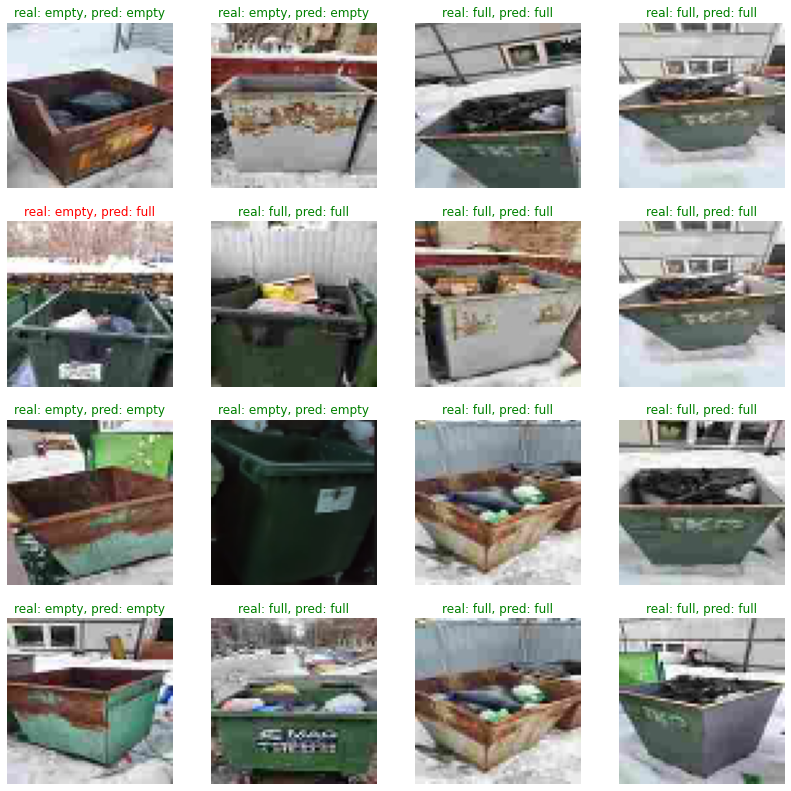

In [52]:
# Result.
predictions = model.predict(test_dataset)

idx = 0
rng = np.random.default_rng()
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14,14))

for i in range(4):
  for j in range(4):
    image, label = test_dataset.next()
    _batch_size = label.shape[0]
    
    local_idx = (int)(_batch_size * rng.uniform())
    global_idx = (idx + local_idx) % len(predictions)

    real_class = 'full' if np.round(label[local_idx]) else 'empty'
    predicted_class = 'full' if np.round(predictions[global_idx][0]) else 'empty'

    axs[i,j].set_title(f'real: {real_class}, pred: {predicted_class}')\
      .set_color('green' if real_class == predicted_class else 'red')
    axs[i,j].imshow(image[local_idx])
    axs[i,j].axis('off')

    idx += _batch_size

plt.show()
